Saving Einstein_ledeNew.jpg to Einstein_ledeNew (5).jpg


<ipython-input-10-91e819777308>:57: FutureWarning: `iterations` is a deprecated argument name for `richardson_lucy`. It will be removed in version 1.0. Please use `num_iter` instead.
  inverse_filter = restoration.richardson_lucy(noisy, kernel, iterations=30)


SNR: 23.173617614647295 dB
MSE: 0.0029161317805391795
RMSE: 0.05400122017639212


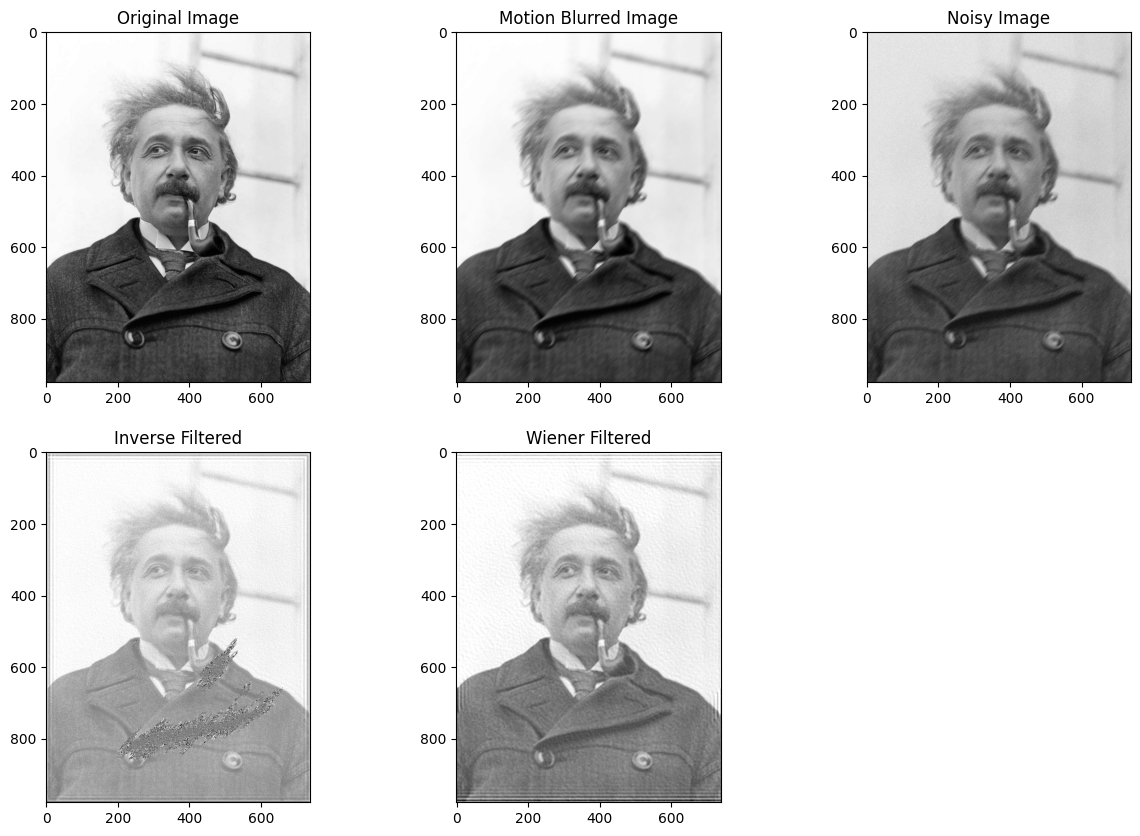

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
from scipy.signal import convolve2d
from scipy.fft import fft2, ifft2, fftshift
from skimage import io, color, util, restoration
from google.colab import files
import cv2


def create_motion_blur_kernel(kernel_size=15, angle=0):
    kernel = np.zeros((kernel_size, kernel_size))
    kernel[int((kernel_size - 1) / 2), :] = np.ones(kernel_size)
    kernel = scipy.ndimage.rotate(kernel, angle, reshape=False)
    return kernel / kernel.sum()

def apply_motion_blur(image, kernel):
    return convolve2d(image, kernel, boundary='symm', mode='same')

def add_gaussian_noise(image, mean=0, var=0.001):
    row, col = image.shape
    sigma = var**0.5
    gauss = np.random.normal(mean, sigma, (row, col))
    noisy = image + gauss
    return noisy

def calculate_snr(original, noisy):
    signal_power = np.sum(original ** 2)
    noise_power = np.sum((original - noisy) ** 2)
    snr = 10 * np.log10(signal_power / noise_power)
    return snr

def calculate_mse_rmse(original, deblurred):
    mse = np.mean((original - deblurred) ** 2)
    rmse = np.sqrt(mse)
    return mse, rmse


# Upload
uploaded = files.upload()
filename = next(iter(uploaded))
image = io.imread(filename)

# Convert to grayscale
image_gray = color.rgb2gray(image)
image_gray = image_gray.astype(np.float32)

kernel = create_motion_blur_kernel(kernel_size=15, angle=45)

blurred = apply_motion_blur(image_gray, kernel)

# Add noise
noisy = add_gaussian_noise(blurred)
#noisy = blurred

# Inverse filtering
inverse_filter = restoration.richardson_lucy(noisy, kernel, iterations=30)

# Wiener filtering
wiener_filter = restoration.wiener(noisy, kernel, 0.1)

# Display results
plt.figure(figsize=(15, 10))
plt.subplot(231), plt.imshow(image_gray, cmap='gray'), plt.title('Original Image')
plt.subplot(232), plt.imshow(blurred, cmap='gray'), plt.title('Motion Blurred Image')
plt.subplot(233), plt.imshow(noisy, cmap='gray'), plt.title('Noisy Image')
plt.subplot(234), plt.imshow(inverse_filter, cmap='gray'), plt.title('Inverse Filtered')
plt.subplot(235), plt.imshow(wiener_filter, cmap='gray'), plt.title('Wiener Filtered')

# Calculate SNR, MSE, and RMSE
snr = calculate_snr(image_gray, noisy)
mse, rmse = calculate_mse_rmse(image_gray, wiener_filter)
print(f"SNR: {snr} dB")
print(f"MSE: {mse}")
print(f"RMSE: {rmse}")

plt.show()

Saving Einstein_ledeNew.jpg to Einstein_ledeNew (7).jpg
Inverse Filtered Image - MSE: 0.1794435814001342, RMSE: 0.4236078155560095, SNR: 4.140879029142907 dB
Wiener Filtered Image - MSE: 0.05890312461318702, RMSE: 0.24269965927703116, SNR: 8.978774981189037 dB


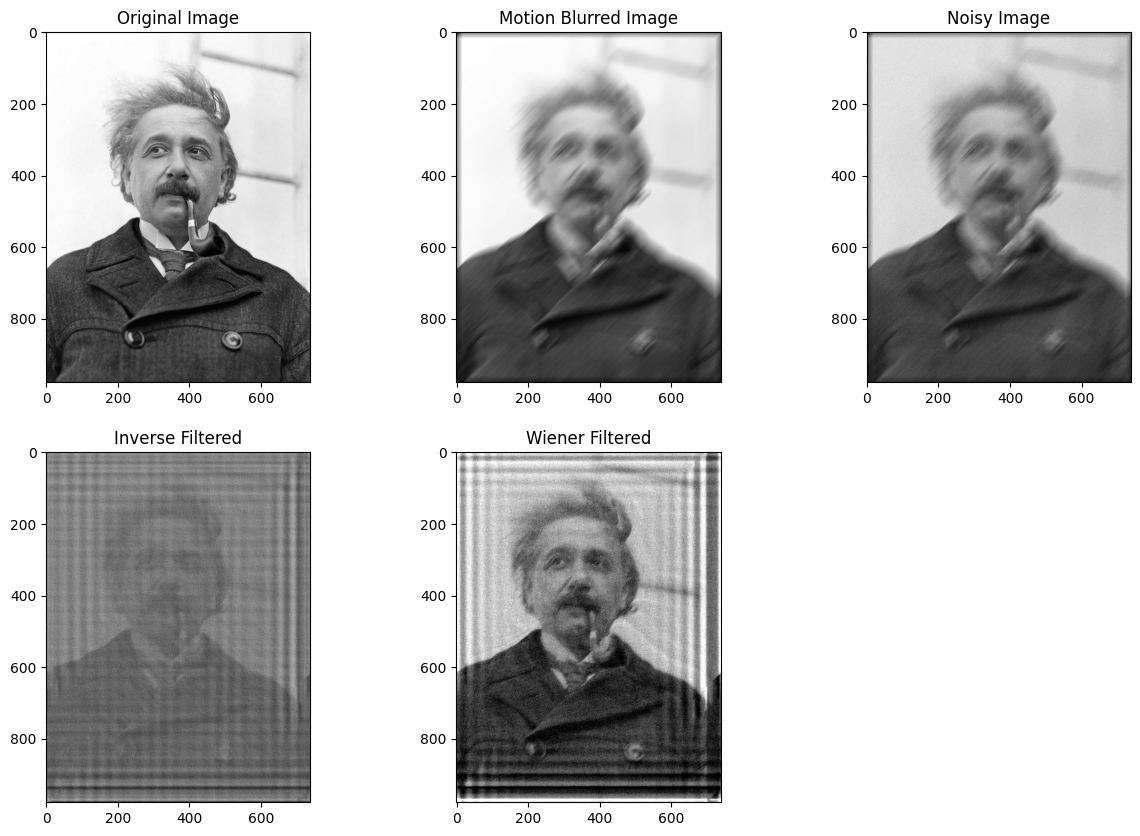

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
from scipy.signal import convolve2d
from scipy.fft import fft2, ifft2, fftshift
from skimage import io, color, util, restoration
from google.colab import files
import cv2

def create_motion_blur_kernel(kernel_size=15, angle=45):
    kernel = np.zeros((kernel_size, kernel_size))
    kernel[int((kernel_size - 1) / 2), :] = np.ones(kernel_size)
    kernel = scipy.ndimage.rotate(kernel, angle, reshape=False)
    return kernel / kernel.sum()

def apply_motion_blur(image, kernel):
    kernel_height, kernel_width = kernel.shape
    image_height, image_width = image.shape

    # Create a padded array to handle edges
    pad_height = kernel_height // 2
    pad_width = kernel_width // 2
    padded_image = np.pad(image, ((pad_height, pad_height), (pad_width, pad_width)), mode='constant')

    output = np.zeros_like(image)

    # convolution
    for y in range(image_height):
        for x in range(image_width):
            output[y, x] = np.sum(kernel * padded_image[y:y + kernel_height, x:x + kernel_width])
    return output


def inverse_filtering(blurred, kernel):
    # Avoid division by zero in frequency domain
    kernel_fft = np.fft.fft2(kernel, s=blurred.shape)
    kernel_fft[np.abs(kernel_fft) < 1e-1] = 1e-1
    blurred_fft = np.fft.fft2(blurred)
    return np.fft.ifft2(blurred_fft / kernel_fft).real

def wiener_filter(blurred, kernel, K=0.01):
    kernel_fft = np.fft.fft2(kernel, s=blurred.shape)
    blurred_fft = np.fft.fft2(blurred)
    denominator = np.abs(kernel_fft) ** 2 + K
    return np.fft.ifft2(blurred_fft * np.conj(kernel_fft) / denominator).real


#Gaussian noise
def add_gaussian_noise(image, mean=0, var=0.001):
    row, col = image.shape
    sigma = var**0.5
    gauss = np.random.normal(mean, sigma, (row, col))
    noisy = image + gauss
    return noisy

def calculate_snr(original, noisy):
    signal_power = np.sum(original ** 2)
    noise_power = np.sum((original - noisy) ** 2)
    snr = 10 * np.log10(signal_power / noise_power)
    return snr

# Function to calculate MSE
def calculate_mse(original, processed):
    return np.mean((original - processed) ** 2)

# Function to calculate RMSE
def calculate_rmse(original, processed):
    return np.sqrt(calculate_mse(original, processed))

# Function to calculate SNR
def calculate_snr(original, noisy):
    signal_power = np.sum(original ** 2)
    noise_power = np.sum((original - noisy) ** 2)
    return 10 * np.log10(signal_power / noise_power)




uploaded = files.upload()
filename = next(iter(uploaded))
image = io.imread(filename)

# Convert to grayscale and normalize
image_gray = color.rgb2gray(image)
image_gray = image_gray.astype(np.float32)

# Create motion blur kernel
kernel = create_motion_blur_kernel(kernel_size=50, angle=45)

# Apply motion blur and add noise
blurred = apply_motion_blur(image_gray, kernel)
noisy = add_gaussian_noise(blurred)

# Perform inverse filtering
inverse_filtered = inverse_filtering(noisy, kernel)

# Perform Wiener filtering
wiener_filtered = wiener_filter(noisy, kernel)

def normalize_image(image):
    image_min, image_max = image.min(), image.max()
    return (image - image_min) / (image_max - image_min)

def adjust_contrast(image, lower_percentile, upper_percentile):
    lower_bound = np.percentile(image, lower_percentile)
    upper_bound = np.percentile(image, upper_percentile)
    image = np.clip(image, lower_bound, upper_bound)
    return normalize_image(image)


wiener_filtered = adjust_contrast(wiener_filtered, 2, 98)


# Calculate MSE, RMSE, and SNR for the inverse filtered image
mse_inverse = calculate_mse(image_gray, inverse_filtered)
rmse_inverse = calculate_rmse(image_gray, inverse_filtered)
snr_inverse = calculate_snr(image_gray, inverse_filtered)

# Calculate MSE, RMSE, and SNR for the Wiener filtered image
mse_wiener = calculate_mse(image_gray, wiener_filtered)
rmse_wiener = calculate_rmse(image_gray, wiener_filtered)
snr_wiener = calculate_snr(image_gray, wiener_filtered)

# Print the results
print(f"Inverse Filtered Image - MSE: {mse_inverse}, RMSE: {rmse_inverse}, SNR: {snr_inverse} dB")
print(f"Wiener Filtered Image - MSE: {mse_wiener}, RMSE: {rmse_wiener}, SNR: {snr_wiener} dB")


plt.figure(figsize=(15, 10))
plt.subplot(231), plt.imshow(image_gray, cmap='gray'), plt.title('Original Image')
plt.subplot(232), plt.imshow(blurred, cmap='gray'), plt.title('Motion Blurred Image')
plt.subplot(233), plt.imshow(noisy, cmap='gray'), plt.title('Noisy Image')
plt.subplot(234), plt.imshow(inverse_filtered, cmap='gray'), plt.title('Inverse Filtered')
plt.subplot(235), plt.imshow(wiener_filtered, cmap='gray'), plt.title('Wiener Filtered')
plt.show()




In [ ]:
print(kernel.shape)

(15, 15)


Saving 22.jpg to 22.jpg
Inverse Filtered Image - MSE: 1.0905423903081415, RMSE: 1.0442903764318339, SNR: -9.277459756190133 dB
Wiener Filtered Image - MSE: 0.17871645163297353, RMSE: 0.4227486861398549, SNR: -1.4226795703826962 dB


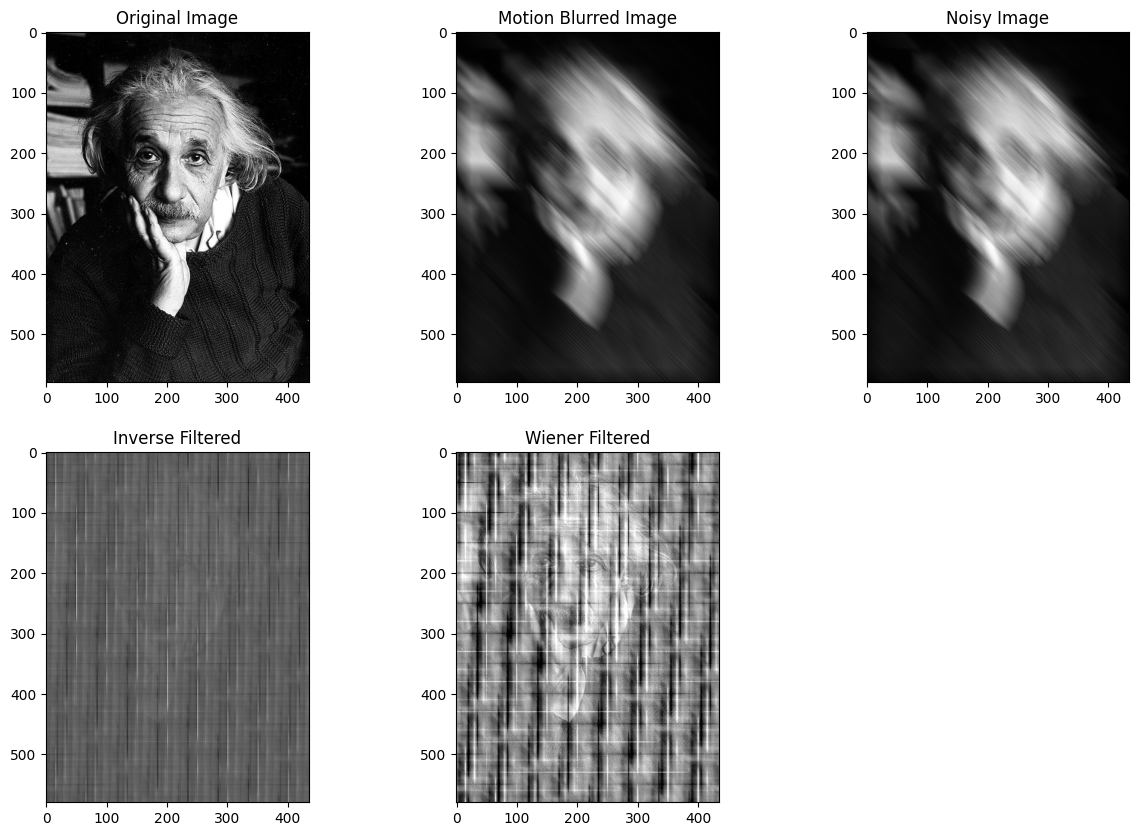

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
from scipy.signal import convolve2d
from scipy.fft import fft2, ifft2, fftshift
from skimage import io, color, util, restoration
from google.colab import files
import cv2

def create_motion_blur_kernel(kernel_size=15, angle=45):
    # kernel = np.zeros((kernel_size, kernel_size))
    kernel = np.eye(kernel_size, kernel_size)
    #kernel[int((kernel_size - 1) / 2), :] = np.ones(kernel_size)
    #kernel = scipy.ndimage.rotate(kernel, angle, reshape=False)
    return kernel / kernel.sum()

def apply_motion_blur(image, kernel):
    kernel_height, kernel_width = kernel.shape
    image_height, image_width = image.shape

    # Create a padded array to handle edges
    pad_height = kernel_height // 2
    pad_width = kernel_width // 2
    padded_image = np.pad(image, ((pad_height, pad_height), (pad_width, pad_width)), mode='constant')

    output = np.zeros_like(image)

    # convolution
    for y in range(image_height):
        for x in range(image_width):
            output[y, x] = np.sum(kernel * padded_image[y:y + kernel_height, x:x + kernel_width])
    return output


def inverse_filtering(blurred, kernel):
    # Avoid division by zero in frequency domain
    kernel_fft = np.fft.fft2(kernel, s=blurred.shape)
    kernel_fft[np.abs(kernel_fft) < 1e-1] = 1e-1
    blurred_fft = np.fft.fft2(blurred)
    return np.fft.ifft2(blurred_fft / kernel_fft).real

def wiener_filter(blurred, kernel, K=0.01):
    kernel_fft = np.fft.fft2(kernel, s=blurred.shape)
    blurred_fft = np.fft.fft2(blurred)
    denominator = np.abs(kernel_fft) ** 2 + K
    return np.fft.ifft2(blurred_fft * np.conj(kernel_fft) / denominator).real


#Gaussian noise
def add_gaussian_noise(image, mean=0, var=0.001):
    row, col = image.shape
    sigma = var**0.5
    gauss = np.random.normal(mean, sigma, (row, col))
    noisy = image + gauss
    return noisy

def calculate_snr(original, noisy):
    signal_power = np.sum(original ** 2)
    noise_power = np.sum((original - noisy) ** 2)
    snr = 10 * np.log10(signal_power / noise_power)
    return snr

# Function to calculate MSE
def calculate_mse(original, processed):
    return np.mean((original - processed) ** 2)

# Function to calculate RMSE
def calculate_rmse(original, processed):
    return np.sqrt(calculate_mse(original, processed))

# Function to calculate SNR
def calculate_snr(original, noisy):
    signal_power = np.sum(original ** 2)
    noise_power = np.sum((original - noisy) ** 2)
    return 10 * np.log10(signal_power / noise_power)




uploaded = files.upload()
filename = next(iter(uploaded))
image = io.imread(filename)

# Convert to grayscale and normalize
image_gray = color.rgb2gray(image)
image_gray = image_gray.astype(np.float32)

# Create motion blur kernel
kernel = create_motion_blur_kernel(kernel_size=50, angle=45)

# Apply motion blur and add noise
blurred = apply_motion_blur(image_gray, kernel)
noisy = add_gaussian_noise(blurred)

# Perform inverse filtering
inverse_filtered = inverse_filtering(noisy, kernel)

# Perform Wiener filtering
wiener_filtered = wiener_filter(noisy, kernel)

def normalize_image(image):
    image_min, image_max = image.min(), image.max()
    return (image - image_min) / (image_max - image_min)

def adjust_contrast(image, lower_percentile, upper_percentile):
    lower_bound = np.percentile(image, lower_percentile)
    upper_bound = np.percentile(image, upper_percentile)
    image = np.clip(image, lower_bound, upper_bound)
    return normalize_image(image)


wiener_filtered = adjust_contrast(wiener_filtered, 2, 98)


# Calculate MSE, RMSE, and SNR for the inverse filtered image
mse_inverse = calculate_mse(image_gray, inverse_filtered)
rmse_inverse = calculate_rmse(image_gray, inverse_filtered)
snr_inverse = calculate_snr(image_gray, inverse_filtered)

# Calculate MSE, RMSE, and SNR for the Wiener filtered image
mse_wiener = calculate_mse(image_gray, wiener_filtered)
rmse_wiener = calculate_rmse(image_gray, wiener_filtered)
snr_wiener = calculate_snr(image_gray, wiener_filtered)

# Print the results
print(f"Inverse Filtered Image - MSE: {mse_inverse}, RMSE: {rmse_inverse}, SNR: {snr_inverse} dB")
print(f"Wiener Filtered Image - MSE: {mse_wiener}, RMSE: {rmse_wiener}, SNR: {snr_wiener} dB")


plt.figure(figsize=(15, 10))
plt.subplot(231), plt.imshow(image_gray, cmap='gray'), plt.title('Original Image')
plt.subplot(232), plt.imshow(blurred, cmap='gray'), plt.title('Motion Blurred Image')
plt.subplot(233), plt.imshow(noisy, cmap='gray'), plt.title('Noisy Image')
plt.subplot(234), plt.imshow(inverse_filtered, cmap='gray'), plt.title('Inverse Filtered')
plt.subplot(235), plt.imshow(wiener_filtered, cmap='gray'), plt.title('Wiener Filtered')
plt.show()




Saving 22.jpg to 22 (2).jpg
Inverse Filtered Image - MSE: 0.16823085058247336, RMSE: 0.410159542839702, SNR: -1.1600906472457482 dB
Wiener Filtered Image - MSE: 0.07637432553731278, RMSE: 0.27635905184616766, SNR: 2.2694918801167905 dB


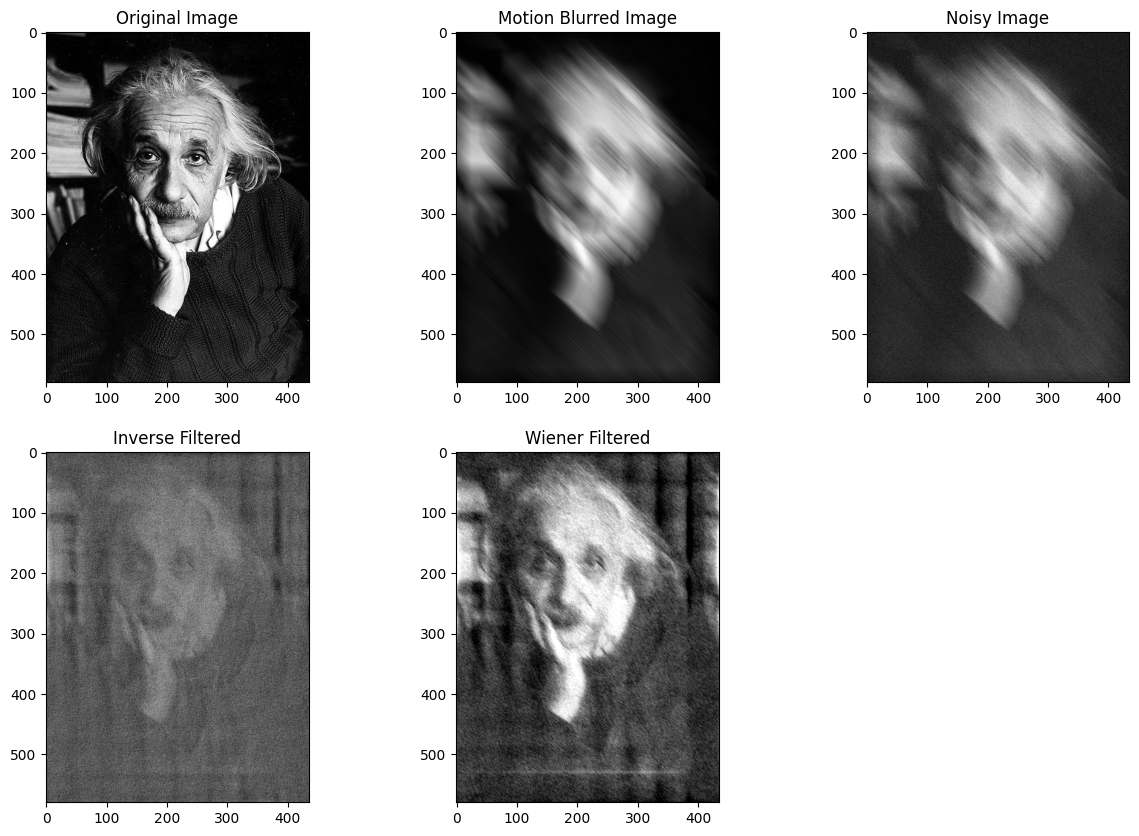

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
from scipy.signal import convolve2d
from scipy.fft import fft2, ifft2, fftshift
from skimage import io, color, util, restoration
from google.colab import files
import cv2

def create_motion_blur_kernel(kernel_size=15, angle=45):
    # kernel = np.zeros((kernel_size, kernel_size))
    kernel = np.eye(kernel_size)
    #kernel[int((kernel_size - 1) / 2), :] = np.ones(kernel_size)
    #kernel = scipy.ndimage.rotate(kernel, angle, reshape=False)
    return kernel / kernel.sum()

def apply_motion_blur(image, kernel):
    kernel_height, kernel_width = kernel.shape
    image_height, image_width = image.shape

    # Create a padded array to handle edges
    pad_height = kernel_height // 2
    pad_width = kernel_width // 2
    padded_image = np.pad(image, ((pad_height, pad_height), (pad_width, pad_width)), mode='constant')

    output = np.zeros_like(image)

    # convolution
    for y in range(image_height):
        for x in range(image_width):
            output[y, x] = np.sum(kernel * padded_image[y:y + kernel_height, x:x + kernel_width])
    return output


def inverse_filtering(blurred, kernel):
    # Avoid division by zero in frequency domain
    kernel_fft = np.fft.fft2(kernel, s=blurred.shape)
    kernel_fft[np.abs(kernel_fft) < 1e-1] = 1e-1
    blurred_fft = np.fft.fft2(blurred)
    return np.fft.ifft2(blurred_fft / kernel_fft).real

def wiener_filter(blurred, kernel, K=0.01):
    kernel_fft = np.fft.fft2(kernel, s=blurred.shape)
    blurred_fft = np.fft.fft2(blurred)
    denominator = np.abs(kernel_fft) ** 2 + K
    return np.fft.ifft2(blurred_fft * np.conj(kernel_fft) / denominator).real


#Gaussian noise
def add_gaussian_noise(image, mean=0, var=0.001):
    row, col = image.shape
    sigma = var**0.5
    gauss = np.random.normal(mean, sigma, (row, col))
    noisy = image + gauss
    return noisy

def calculate_snr(original, noisy):
    signal_power = np.sum(original ** 2)
    noise_power = np.sum((original - noisy) ** 2)
    snr = 10 * np.log10(signal_power / noise_power)
    return snr

# Function to calculate MSE
def calculate_mse(original, processed):
    return np.mean((original - processed) ** 2)

# Function to calculate RMSE
def calculate_rmse(original, processed):
    return np.sqrt(calculate_mse(original, processed))

# Function to calculate SNR
def calculate_snr(original, noisy):
    signal_power = np.sum(original ** 2)
    noise_power = np.sum((original - noisy) ** 2)
    return 10 * np.log10(signal_power / noise_power)




uploaded = files.upload()
filename = next(iter(uploaded))
image = io.imread(filename)

# Convert to grayscale and normalize
image_gray = color.rgb2gray(image)
image_gray = image_gray.astype(np.float32)

# Create motion blur kernel
kernel = create_motion_blur_kernel(kernel_size=50, angle=45)

# Apply motion blur and add noise
blurred = apply_motion_blur(image_gray, kernel)
noisy = add_gaussian_noise(blurred)

# Perform inverse filtering
inverse_filtered = inverse_filtering(noisy, kernel)

# Perform Wiener filtering
wiener_filtered = wiener_filter(noisy, kernel)

def normalize_image(image):
    image_min, image_max = image.min(), image.max()
    return (image - image_min) / (image_max - image_min)

def adjust_contrast(image, lower_percentile, upper_percentile):
    lower_bound = np.percentile(image, lower_percentile)
    upper_bound = np.percentile(image, upper_percentile)
    image = np.clip(image, lower_bound, upper_bound)
    return normalize_image(image)


wiener_filtered = adjust_contrast(wiener_filtered, 2, 98)


# Calculate MSE, RMSE, and SNR for the inverse filtered image
mse_inverse = calculate_mse(image_gray, inverse_filtered)
rmse_inverse = calculate_rmse(image_gray, inverse_filtered)
snr_inverse = calculate_snr(image_gray, inverse_filtered)

# Calculate MSE, RMSE, and SNR for the Wiener filtered image
mse_wiener = calculate_mse(image_gray, wiener_filtered)
rmse_wiener = calculate_rmse(image_gray, wiener_filtered)
snr_wiener = calculate_snr(image_gray, wiener_filtered)

# Print the results
print(f"Inverse Filtered Image - MSE: {mse_inverse}, RMSE: {rmse_inverse}, SNR: {snr_inverse} dB")
print(f"Wiener Filtered Image - MSE: {mse_wiener}, RMSE: {rmse_wiener}, SNR: {snr_wiener} dB")


plt.figure(figsize=(15, 10))
plt.subplot(231), plt.imshow(image_gray, cmap='gray'), plt.title('Original Image')
plt.subplot(232), plt.imshow(blurred, cmap='gray'), plt.title('Motion Blurred Image')
plt.subplot(233), plt.imshow(noisy, cmap='gray'), plt.title('Noisy Image')
plt.subplot(234), plt.imshow(inverse_filtered, cmap='gray'), plt.title('Inverse Filtered')
plt.subplot(235), plt.imshow(wiener_filtered, cmap='gray'), plt.title('Wiener Filtered')
plt.show()


